# Results Analysis

This notebook is intended to read a simulation results file and report the analysis.

In [1]:
%matplotlib inline

import os
import sys 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from networkx.readwrite import json_graph

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.results import Results
from cloudscope.viz import draw_topology
from cloudscope.viz import plot_workload
from cloudscope.viz import plot_message_traffic
from cloudscope.results.analysis import create_per_replica_dataframe as create_dataframe
from cloudscope.results.analysis import create_messages_dataframe

import matplotlib
matplotlib.style.use('ggplot')

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Specify a path to a results file 
FIXTURES = os.path.join("..", "fixtures", "results")
# RESULTS  = os.path.join(FIXTURES, "raft-quorum-20160411.json")
# RESULTS  = os.path.join(FIXTURES, "tagging-quorum-20160411.json")
# RESULTS  = os.path.join(FIXTURES, 'federated', "federated-1user-4050T.json")
# RESULTS = os.path.join("..", "eventually-consistent-large-group-20160630.json")
# RESULTS = os.path.join("..", "large-consensus-group-20160630.json")
RESULTS = os.path.join("..", "federated-consistency-20160630.json")



def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        return Results.load(f)

# Load the data
results = get_results_data()

In [3]:
# Create the data frame for further analysis
df = create_dataframe(results)
df 

,committed writes,completed reads,completed writes,dropped writes,empty reads,forked writes,mean commit latency (ms),mean dropped write latency (ms),mean message latency (ms),mean read latency (ms),...,reads,recv,replica,sent,stale reads,unforked writes,visible writes,writes,partially replicated writes,visibility ratio
0,61,117,61,17,NaN,0,3529.169042,626.456120,126.478360,0,...,117,10536,a0,10536,53,16,59,78,19,0.756410
1,35,69,75,4,NaN,1,4180.196281,1124.922382,30.021909,0,...,69,2945,a1,2946,13,4,29,40,11,0.725000
2,46,49,100,6,1,-1,4476.572220,1652.685074,29.953604,0,...,50,2945,a2,2946,7,3,37,54,17,0.685185
3,56,108,118,3,NaN,3,4288.891893,2107.862626,30.089128,0,...,108,2945,a3,2946,17,7,48,62,14,0.774194
4,83,121,83,NaN,NaN,2,2945.905661,NaN,295.935202,0,...,121,15880,b0,15880,43,6,68,83,15,0.819277
5,73,118,76,NaN,NaN,0,4276.798166,NaN,30.024282,0,...,118,2945,b1,2946,10,12,58,76,18,0.763158
6,54,71,54,NaN,NaN,0,4156.216918,NaN,30.008339,0,...,71,2945,b2,2946,7,4,45,54,9,0.833333
7,72,102,75,NaN,NaN,1,4456.064766,NaN,30.132789,0,...,102,2945,b3,2946,7,2,60,75,15,0.800000
8,48,80,48,14,NaN,-2,3456.733985,633.572918,131.490966,0,...,80,10637,c0,10637,40,15,42,62,20,0.677419
9,73,90,160,12,NaN,0,4348.088533,1413.235092,30.002071,0,...,90,2945,c1,2946,13,5,64,87,23,0.735632


# Results 

In [4]:
print results.print_details()

Simulation: Federated Consistency (Cloudscope v0.4)
A large group of eventually consistent nodes in 5 locations with a central core consensus group.

Ran on: Jun 30, 2016 at 16:42 UTC (42 seconds)

Settings
Constant                      N/A
Seed                         None
Access Stddev                 180
Do Rumoring                     0
Access Mean                  1200
Move Prob                    0.05
Latency Stddev               50.0
Description          A large group of eventually consistent nodes in 5 locations with a central core consensus group.
Integration             federated
Latency Mean                  630
Default Latency               800
Do Gossip                       1
Tick Metric                  6300
Max Sim Time              4640000
Random Seed                    42
Switch Prob                   0.1
Election Timeout     [6300, 12600]
Local Prob                    0.6
Heartbeat Interval           3150
Default Consistency        strong
Variable                15-1

## Topology

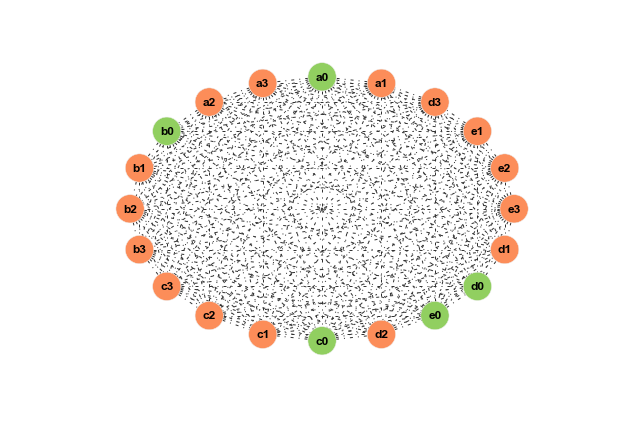

In [5]:
draw_topology(json_graph.node_link_graph(results.topology))

In [6]:
print results.print_topology()

a0: Alpha 0 (alpha-site, strong) 30-50.0ms connection
a1: Alpha 1 (alpha-site, eventual) 30-50.0ms connection
a2: Alpha 2 (alpha-site, eventual) 30-50.0ms connection
a3: Alpha 3 (alpha-site, eventual) 30-50.0ms connection
b0: Bravo 0 (bravo-site, strong) 30-50.0ms connection
b1: Bravo 1 (bravo-site, eventual) 30-50.0ms connection
b2: Bravo 2 (bravo-site, eventual) 30-50.0ms connection
b3: Bravo 3 (bravo-site, eventual) 30-50.0ms connection
c0: Charlie 0 (charlie-site, strong) 30-50.0ms connection
c1: Charlie 1 (charlie-site, eventual) 30-50.0ms connection
c2: Charlie 2 (charlie-site, eventual) 30-50.0ms connection
c3: Charlie 3 (charlie-site, eventual) 30-50.0ms connection
d0: Delta 0 (delta-site, strong) 30-50.0ms connection
d1: Delta 1 (delta-site, eventual) 30-50.0ms connection
d2: Delta 2 (delta-site, eventual) 30-50.0ms connection
d3: Delta 3 (delta-site, eventual) 30-50.0ms connection
e0: Echo 0 (echo-site, strong) 30-50.0ms connection
e1: Echo 1 (echo-site, eventual) 30-50.0ms c

## Workload

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

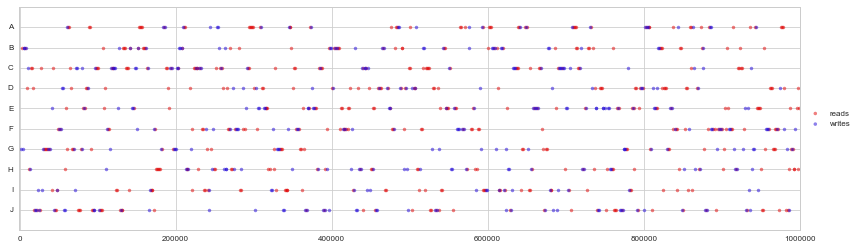

In [7]:
# Create the workload timeline plot 
plot_workload(results, series='objects')

In [8]:
# Create the sent messages timeline
# plot_message_traffic(results.results['sent'])

In [9]:
# Create Message Traffic Data Frame 
def count(nums):
    return sum(nums)
            
# msgs = create_messages_dataframe(results)

In [10]:
# ax = sns.barplot(y='sent', x='replica', hue='type', data=msgs, estimator=count)

## Metrics 

The following metrics are reported from the results.

### Reads and Writes

Accesses
2112 Total Reads, 1481 Total Writes 
105.6 average reads per replica
74.0 average writes per replica



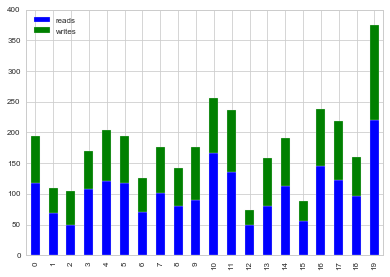

In [11]:
# Extract accesses 
accesses = pd.DataFrame(df, columns=['reads', 'writes'])

print (
    "Accesses\n"
    "========\n"
    "{} Total Reads, {} Total Writes \n"
    "{:0.1f} average reads per replica\n"
    "{:0.1f} average writes per replica\n"
).format(
    df.reads.sum(), df.writes.sum(), df.reads.mean(), df.writes.mean()
)

accesses.plot(kind='bar', stacked=True)

### Stale Reads

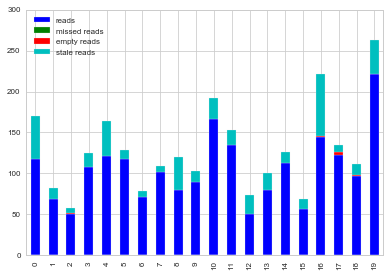

In [12]:
errors = pd.DataFrame(df, columns=['reads', 'missed reads', 'empty reads', 'stale reads'])
errors.plot(kind='bar', stacked=True)

### Forked Writes

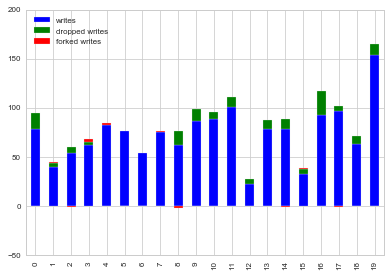

In [13]:
errors = pd.DataFrame(df, columns=['writes', 'dropped writes', 'forked writes'])
errors.plot(kind='bar', stacked=True)

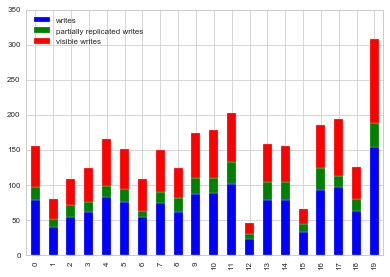

In [14]:
errors = pd.DataFrame(df, columns=['writes', 'partially replicated writes', 'visible writes'])
errors.plot(kind='bar', stacked=True)

### Read and Write Costs

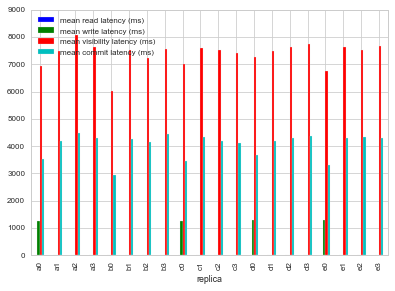

In [15]:
data=pd.DataFrame(df, columns=['replica', 'mean read latency (ms)', 'mean write latency (ms)', 'mean visibility latency (ms)', 'mean commit latency (ms)'])
data.plot(kind='bar', x='replica')